In [4]:
import os
import re
import gc
import sys
import time
import json
import random
import unicodedata
import multiprocessing
from functools import partial, lru_cache

import emoji

import numpy as np
import pandas as pd
import joblib
from tqdm import tqdm, tqdm_notebook

from nltk import TweetTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
from gensim.models import KeyedVectors
from keras_preprocessing.sequence import pad_sequences

class SequenceBucketCollator():
    def __init__(self, choose_length, sequence_index, length_index, label_index=None):
        self.choose_length = choose_length
        self.sequence_index = sequence_index
        self.length_index = length_index
        self.label_index = label_index
        
    def __call__(self, batch):
        batch = [torch.stack(x) for x in list(zip(*batch))]
        
        sequences = batch[self.sequence_index]
        lengths = batch[self.length_index]
        
        length = self.choose_length(lengths)
        mask = torch.arange(start=maxlen, end=0, step=-1) < length
        padded_sequences = sequences[:, mask]
        
        batch[self.sequence_index] = padded_sequences
        
        if self.label_index is not None:
            return [x for i, x in enumerate(batch) if i != self.label_index], batch[self.label_index]
    
        return batch


CUSTOM_TABLE = str.maketrans(
    {
        "\xad": None,
        "\x7f": None,
        "\ufeff": None,
        "\u200b": None,
        "\u200e": None,
        "\u202a": None,
        "\u202c": None,
        "‘": "'",
        "’": "'",
        "`": "'",
        "“": '"',
        "”": '"',
        "«": '"',
        "»": '"',
        "ɢ": "G",
        "ɪ": "I",
        "ɴ": "N",
        "ʀ": "R",
        "ʏ": "Y",
        "ʙ": "B",
        "ʜ": "H",
        "ʟ": "L",
        "ғ": "F",
        "ᴀ": "A",
        "ᴄ": "C",
        "ᴅ": "D",
        "ᴇ": "E",
        "ᴊ": "J",
        "ᴋ": "K",
        "ᴍ": "M",
        "Μ": "M",
        "ᴏ": "O",
        "ᴘ": "P",
        "ᴛ": "T",
        "ᴜ": "U",
        "ᴡ": "W",
        "ᴠ": "V",
        "ĸ": "K",
        "в": "B",
        "м": "M",
        "н": "H",
        "т": "T",
        "ѕ": "S",
        "—": "-",
        "–": "-",
    }
)

WORDS_REPLACER = [
    ("sh*t", "shit"),
    ("s**t", "shit"),
    ("f*ck", "fuck"),
    ("fu*k", "fuck"),
    ("f**k", "fuck"),
    ("f*****g", "fucking"),
    ("f***ing", "fucking"),
    ("f**king", "fucking"),
    ("p*ssy", "pussy"),
    ("p***y", "pussy"),
    ("pu**y", "pussy"),
    ("p*ss", "piss"),
    ("b*tch", "bitch"),
    ("bit*h", "bitch"),
    ("h*ll", "hell"),
    ("h**l", "hell"),
    ("cr*p", "crap"),
    ("d*mn", "damn"),
    ("stu*pid", "stupid"),
    ("st*pid", "stupid"),
    ("n*gger", "nigger"),
    ("n***ga", "nigger"),
    ("f*ggot", "faggot"),
    ("scr*w", "screw"),
    ("pr*ck", "prick"),
    ("g*d", "god"),
    ("s*x", "sex"),
    ("a*s", "ass"),
    ("a**hole", "asshole"),
    ("a***ole", "asshole"),
    ("a**", "ass"),
]

REGEX_REPLACER = [
    (re.compile(pat.replace("*", "\*"), flags=re.IGNORECASE), repl)
    for pat, repl in WORDS_REPLACER
]

RE_SPACE = re.compile(r"\s")
RE_MULTI_SPACE = re.compile(r"\s+")

NMS_TABLE = dict.fromkeys(
    i for i in range(sys.maxunicode + 1) if unicodedata.category(chr(i)) == "Mn"
)

HEBREW_TABLE = {i: "א" for i in range(0x0590, 0x05FF)}
ARABIC_TABLE = {i: "ا" for i in range(0x0600, 0x06FF)}
CHINESE_TABLE = {i: "是" for i in range(0x4E00, 0x9FFF)}
KANJI_TABLE = {i: "ッ" for i in range(0x2E80, 0x2FD5)}
HIRAGANA_TABLE = {i: "ッ" for i in range(0x3041, 0x3096)}
KATAKANA_TABLE = {i: "ッ" for i in range(0x30A0, 0x30FF)}

TABLE = dict()
TABLE.update(CUSTOM_TABLE)
TABLE.update(NMS_TABLE)
# Non-english languages
TABLE.update(CHINESE_TABLE)
TABLE.update(HEBREW_TABLE)
TABLE.update(ARABIC_TABLE)
TABLE.update(HIRAGANA_TABLE)
TABLE.update(KATAKANA_TABLE)
TABLE.update(KANJI_TABLE)


EMOJI_REGEXP = emoji.get_emoji_regexp()

UNICODE_EMOJI_MY = {
    k: f" EMJ {v.strip(':').replace('_', ' ')} "
    for k, v in emoji.UNICODE_EMOJI_ALIAS_ENGLISH.items()
}


def my_demojize(string: str) -> str:
    def replace(match):
        return UNICODE_EMOJI_MY.get(match.group(0), match.group(0))

    return re.sub("\ufe0f", "", EMOJI_REGEXP.sub(replace, string))


def normalize(text: str) -> str:
    text = my_demojize(text)

    text = RE_SPACE.sub(" ", text)
    text = unicodedata.normalize("NFKD", text)
    text = text.translate(TABLE)
    text = RE_MULTI_SPACE.sub(" ", text).strip()

    for pattern, repl in REGEX_REPLACER:
        text = pattern.sub(repl, text)

    return text


PORTER_STEMMER = PorterStemmer()
LANCASTER_STEMMER = LancasterStemmer()
SNOWBALL_STEMMER = SnowballStemmer("english")

def word_forms(word):
    yield word
    yield word.lower()
    yield word.upper()
    yield word.capitalize()
    yield PORTER_STEMMER.stem(word)
    yield LANCASTER_STEMMER.stem(word)
    yield SNOWBALL_STEMMER.stem(word)
    
def maybe_get_embedding(word, model):
    for form in word_forms(word):
        if form in model:
            return model[form]

    word = word.strip("-'")
    for form in word_forms(word):
        if form in model:
            return model[form]

    return None


def gensim_to_embedding_matrix(word2index, path):
    model = KeyedVectors.load(path, mmap="r")
    embedding_matrix = np.zeros((max(word2index.values()) + 1, model.vector_size), dtype=np.float32)
    unknown_words = []

    for word, i in word2index.items():
        maybe_embedding = maybe_get_embedding(word, model)
        if maybe_embedding is not None:
            embedding_matrix[i] = maybe_embedding
        else:
            unknown_words.append(word)

    return embedding_matrix, unknown_words

/home/ubuntu/mambaforge/envs/trainbert/lib/python3.7/site-packages/ipykernel_launcher.py:170: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
/home/ubuntu/mambaforge/envs/trainbert/lib/python3.7/site-packages/ipykernel_launcher.py:174: DeprecationWarning: 'emoji.UNICODE_EMOJI_ALIAS_ENGLISH' is deprecated and will be removed in version 2.0.0. Use 'emoji.EMOJI_DATA' instead.
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'


In [6]:
%%time

test1 = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test_private_expanded.csv')
test2 = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv')
test = pd.concat([test1, test2])

CPU times: user 1.74 s, sys: 211 ms, total: 1.95 s
Wall time: 1.95 s


In [7]:
%%time
with multiprocessing.Pool(processes=4) as pool:
     text_list = pool.map(normalize, test.comment_text.tolist())

CPU times: user 289 ms, sys: 284 ms, total: 573 ms
Wall time: 3min 37s


In [8]:
%%time
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

test_word_sequences = []
word_dict = {}
word_index = 1

for doc in text_list:
    word_seq = []
    for token in tknzr.tokenize(doc):
        if token not in word_dict:
            word_dict[token] = word_index
            word_index += 1
        word_seq.append(word_dict[token])
    test_word_sequences.append(word_seq)

CPU times: user 1min 27s, sys: 692 ms, total: 1min 28s
Wall time: 1min 28s


In [9]:
%%time

test_lengths = torch.from_numpy(np.array([len(x) for x in test_word_sequences]))
maxlen = test_lengths.max() 
print(f"Max len = {maxlen}")
maxlen = min(maxlen, 400)

x_test_padded = torch.tensor(pad_sequences(test_word_sequences, maxlen=maxlen))
test_collator = SequenceBucketCollator(torch.max, sequence_index=0, length_index=1)

del text_list, test_word_sequences, tknzr
gc.collect()

Max len = 364
CPU times: user 3.36 s, sys: 345 ms, total: 3.71 s
Wall time: 3.27 s


21

In [10]:
%%time

glove_matrix, _ = gensim_to_embedding_matrix(
    word_dict,
    "../input/gensim-embeddings-dataset/glove.840B.300d.gensim",
)

crawl_matrix, _ = gensim_to_embedding_matrix(
    word_dict, 
    "../input/gensim-embeddings-dataset/crawl-300d-2M.gensim",
)

# para_matrix, _ = gensim_to_embedding_matrix(
#     word_dict, 
#     "../input/gensim-embeddings-dataset/paragram_300_sl999.gensim",
# )

w2v_matrix, _ = gensim_to_embedding_matrix(
    word_dict, 
    "../input/gensim-embeddings-dataset/GoogleNews-vectors-negative300.gensim",
)

CPU times: user 1min 45s, sys: 11.8 s, total: 1min 56s
Wall time: 3min 13s


In [11]:
%%time

def one_hot_char_embeddings(word2index, char_vectorizer):
    words = [""] * (max(word2index.values()) + 1)
    for word, i in word2index.items():
        words[i] = word

    return char_vectorizer.transform(words).toarray().astype(np.float32)

char_matrix = one_hot_char_embeddings(
    word_dict,
    joblib.load('./models/char_vectorizer.joblib'),
)

CPU times: user 1.35 s, sys: 773 ms, total: 2.13 s
Wall time: 2.13 s


In [13]:
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 6 * LSTM_UNITS

class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)
        x = x.permute(0, 3, 2, 1)
        x = super(SpatialDropout, self).forward(x)
        x = x.permute(0, 3, 2, 1)
        x = x.squeeze(2)
        return x
    
    
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, output_aux_sub=11):
        super(NeuralNet, self).__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(embedding_matrix.shape[0], embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        
        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS + 6 + output_aux_sub, 1)
        self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, 6)
        self.linear_sub_out = nn.Linear(DENSE_HIDDEN_UNITS, output_aux_sub)
        
    def forward(self, x, lengths=None):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        avg_pool1 = torch.mean(h_lstm1, 1)
        avg_pool2 = torch.mean(h_lstm2, 1)
        max_pool2, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((avg_pool1, max_pool2, avg_pool2), 1)
        h_conc_linear1  = F.relu(self.linear1(h_conc))
        h_conc_linear2  = F.relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2

        aux_result = self.linear_aux_out(hidden)
        sub_result = self.linear_sub_out(hidden)
        result = self.linear_out(torch.cat((hidden, aux_result, sub_result), 1))
        out = torch.cat([result, aux_result, sub_result], 1)
        return out
    
    
def get_lstm_preds(model_name, embedding_matrix):
    model = NeuralNet(embedding_matrix)
    temp_dict = torch.load('./models/' + model_name)
    temp_dict['embedding.weight'] = torch.tensor(embedding_matrix)
    model.load_state_dict(temp_dict)
    model = model.cuda()
    for param in model.parameters():
        param.requires_grad=False
    model = model.eval()
    
    batch_size = 128
    test_dataset = data.TensorDataset(x_test_padded, test_lengths)
    test_loader = data.DataLoader(test_dataset, batch_size=batch_size, collate_fn=test_collator)
    
    preds = np.zeros((len(test_dataset), 18), dtype=np.float32)
    with torch.no_grad():
        for i, (x_batch) in enumerate(test_loader):
            X_1 = x_batch[0].cuda()
            y_pred = torch.sigmoid(model(X_1)).cpu().numpy()
            preds[i * batch_size:(i + 1) * batch_size] = y_pred
            
    return preds

In [14]:
%%time

model_name = 'Notebook_100_5.bin'

embedding_matrix = np.concatenate([glove_matrix, crawl_matrix, w2v_matrix, char_matrix], axis=1)

print(model_name)
preds = get_lstm_preds(model_name, embedding_matrix)
all_lstm_preds = preds
gc.collect()

Notebook_100_5.bin
CPU times: user 58 s, sys: 6.24 s, total: 1min 4s
Wall time: 1min 10s


15

In [15]:
all_lstm_preds.shape

(194640, 18)

In [16]:
def simple_magic(preds):
    return (
        preds[:, 0] + preds[:, 1] * 0.05 - preds[:, -1] * 0.05 - preds[:, 4] * 0.05
    )

def sophisticated_magic(preds):
    return (
        preds[:, 0] + preds[:, 1] * 0.05 - preds[:, -1] * 0.03 - preds[:, 4] * 0.03
    ) - preds[:, 14] * (1 - preds[:, 0]) * 0.05 - preds[:, 10] * (1 - preds[:, 0]) * 0.05

In [17]:
output_df = pd.DataFrame(
    {
        "id": test["id"],
        "target_0": all_lstm_preds[:, 0],
        "target_simple":  simple_magic(all_lstm_preds),
        "target_sophisticated": sophisticated_magic(all_lstm_preds)
    }
)

In [18]:
output_df.head(10)

,id,target_0,target_simple,target_sophisticated
0,7097320,0.012407,0.012589,0.012743
1,7097321,0.062575,0.065078,0.065262
2,7097322,0.297736,0.310062,0.310544
3,7097323,0.032133,0.031489,0.032177
4,7097324,0.009788,0.009807,0.009970
5,7097325,0.008833,0.008616,0.008843
6,7097326,0.788841,0.825140,0.826261
7,7097327,0.278379,0.288902,0.289794
8,7097328,0.006026,0.005655,0.005901
9,7097329,0.050550,0.049884,0.051079


In [20]:
output_df.to_csv("./models/lstm_5_targets.csv")

In [21]:
real_target = test["toxicity"]

In [22]:
fn_bin = lambda x: 1 if x >= 0.5 else 0
real_target_bin = real_target.map(fn_bin)

In [24]:
real_target_bin.value_counts()

0    179192
1     15448
Name: toxicity, dtype: int64

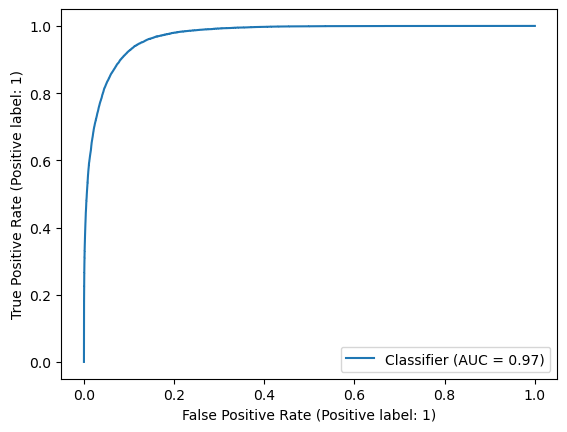

In [27]:
from sklearn.metrics import roc_curve, RocCurveDisplay

RocCurveDisplay.from_predictions(real_target_bin, output_df["target_0"])

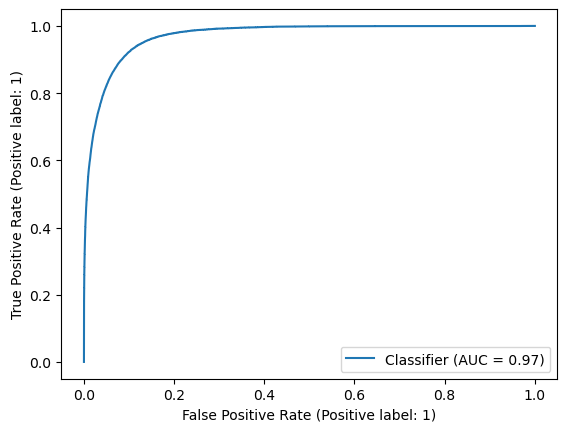

In [28]:
RocCurveDisplay.from_predictions(real_target_bin, output_df["target_simple"])

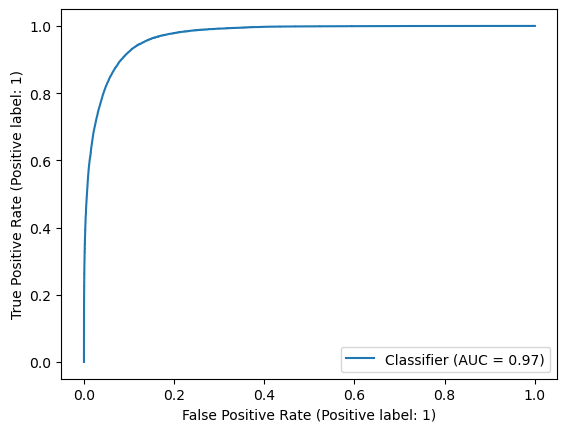

In [29]:
RocCurveDisplay.from_predictions(real_target_bin, output_df["target_sophisticated"])